## Import dependencies

In [131]:
from calendar import monthrange
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.cluster import FeatureAgglomeration
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder

## Load training data frame

In [2]:
df_train = pd.read_excel("data/Vehicles_export_prices_scaled_train_eng.xlsx")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99071 entries, 0 to 99070
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(42), object(59)
memory usage: 80.1+ MB


In [4]:
df_train.head()

,RPAKREP_VEHICLE_HKEY,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,...,CUSTOMER_SALE_GROUP_NAME,CUSTOMER_SALE_GROUP2,CUSTOMER_SALE_GROUP2_NAME,SCALED_CURRENT_VALUE,SCALED_INVENTURAL_VALUE,SCALED_REPORT_VALUE,SCALED_VALUATION_PRICE,SCALED_GUIDE_PRICE,SCALED_TOTAL_SALES_PRICE_BASIS,SCALED_TOTAL_SALE_PRICE
0,77c1af48604226d47b2ccf7be44df009,44.0,TA,TOY,WF01XXERK1JR43779,FOR,Ford,ECS,ECOSPORT 1.0 Titanium Eco,NaN,...,EV privat,EVPR,Endverbraucher private,0.052907,0.000000,0.950043,0.0,0.002975,0.011018,0.011321
1,39587e4f9324333232d2ffaa2f314e6d,12.0,44,VOL,YV1XZK7V5S2487523,VOL,Volvo,XC4,"XC40 B3 B DKG Core 120 kW, 5-t",536K7170F1,...,NaN,NaN,NaN,0.061605,0.000000,0.950043,0.0,0.006136,0.026411,0.019844
2,a91470879cf756368c1d0099a2fa939a,27.0,33,SKO,WF0DXXSK0RX009819,FOR,Ford,TOC,Tourneo Connect 2.0 EcoBl,26,...,EV privat,EVPR,Endverbraucher private,0.063286,0.000000,0.950043,0.0,0.001378,0.022102,0.022053
3,61363a68ff967e7f0c4b80b46a55b141,33.0,K1,V,WVWZZZAWZPU075160,V,Volkswagen,POL,"POLO LIFE 1,0 L 59 KW (80 PS)",AE13GV,...,Interne Kunden,INT,Interne Kunden,0.042565,0.029537,0.897257,0.0,0.001378,0.000000,0.000572
4,fd5b09f7d857904d03a36d1a479f2ca4,10.0,96,FOR,WF0PXXGCHPRC20073,FOR,Ford,FOC,FOCUS TITA 5W 1.0T 125 MHEV M6,15,...,NaN,NaN,NaN,0.054914,0.000000,0.950043,0.0,0.004863,0.019715,0.013360


## Split train and test set

In [5]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.2, random_state=0)

## Data frame preparation

### Manual dtype correction

In [6]:
dtypes = {
    "date": "datetime64[ns]",
    "num": np.float64,
    "str": pd.StringDtype(),
}

columns_of_interest = {
    # "RPAKREP_VEHICLE_HKEY": "str",
    "COMPANY": "str",
    "OFFICE": "str",
    "OFFICE_MAIN_BRAND": "str",
    "CHASSIS_NUMBER": "str",
    "MANUFACTURER_SHORT": "str",
    "MANUFACTURER": "str",
    "VEHICLE_GROUP": "str",
    "VEHICLE_TYPE": "str",
    "MODEL_CODE": "str",
    "VARIANT": "str",
    "MILEAGE": "num",
    # "OPERATING_HOURS": "num",
    # "MILAGE_IN_FIELD": "num",
    "MILAGE_SALES": "num",
    # "OPERATING_HOURS_SALES": "num",
    # "RIM_KEY": "str",
    "COLOR_CODE": "str",
    "COLOR_CODE_NAME": "str",
    "COLOR": "str",
    "COLOR_TYPE": "str",
    "UPHOLSTERY_CODE": "str",
    "UPHOLSTERY": "str",
    "UPHOLSTERY_CODE_ALT": "str",
    # "CERTIFICATE_TYPE": "str",
    # "CERTIFICATE_TYPE_DATE": "num",
    "FACTORY_NUMBER": "str",
    "ENGINE_ID": "str",
    "ENGINE_TYPE": "str",
    "ENGINE_ID_ALT": "str",
    "TRANSMISSION": "str",
    "TRANSMISSION_TYPE": "str",
    "TRANSMISSION_ID": "str",
    "TRANSMISSION_SHORT": "str",
    "TRANSMISSION_NAME": "str",
    "RIMS": "str",
    "FRONT_TIRES": "str",
    # "FRONT_TIRES_CONDITION": "num",
    "REAR_TIRES": "str",
    # "REAR_TIRES_CONDITION": "num",
    "NUMBER_DOORS": "num",
    "NUMBER_SEATS": "num",
    "PERMITTED_TOTAL_WEIGHT": "num",
    "MAX_TRAILOR_LOAD": "num",
    "CURB_WEIGHT": "num",
    "YEAR_CONSTRUCTION": "num",
    "CONSTRUCTION_MONTH": "num",
    "NUMBER_AXLE": "num",
    "NUMBER_ENGINE_CYLINDER": "num",
    # "REPAIR_RKZ": "num",
    # "OPTICAL_CONDITION": "num",
    # "TECHNICAL_CONDITION": "num",
    "ACCIDENT_VEHICLE": "str",
    # "COMMISSION_NUMBER": "str",
    "HORSEPOWER": "num",
    "KW": "num",
    "CCM": "num",
    "NUMBER_OWNERS": "num",
    "IS_USED_CAR": "num",
    "LEASING_CONTRACT_DATE": "date",
    "LEASING_START": "date",
    "LEASING_END": "date",
    "LEASING_MILAGE": "num",
    # "PAINT_TYPE": "str",
    "FINANCING_TYPE": "str",
    "FINANCING_TYPE_NAME": "str",
    "KAT_VEHICLE": "str",
    "FUEL_TYPE": "str",
    "FUEL_TYPE_NAME": "str",
    "DRIVE_TYPE": "str",
    "DRIVE_TYPE_NAME": "str",
    "VEHICLE_MODEL_ID": "str",
    "VEHICLE_MODEL_ID_NAME": "str",
    "COMMISSION_TYPE": "str",
    "COMMISSION_TYPE_NAME": "str",
    "DEMONSTRATION_STATUS": "str",
    "PURCHASE_DATE": "date",
    "PURCHASE_BOOKING_DATE": "date",
    "PURCHASE_MILAGE": "num",
    # "PURCHASE_OPERATION_HOURS": "num",
    "PRICE_LIST": "num",
    # "DAY_OF_REGISTRATION": "str",
    "AT_LOCATION_SINCE": "num",
    "LAID_UP_TIME": "num",
    "SOLD_CUSTOMER_ID": "str",
    "SOLD_INVOICE_COSTUMER_ID": "str",
    "MILAGE_SALE": "num",
    # "OPERATION_HOURS_SALE": "num",
    # "SOLD_INVOICE_COSTUMER_ID2": "str",
    "CUSTOMER_TYPE": "str",
    # "CUSTOMER_GROUP": "str",
    # "CUSTOMER_GROUP_NAME": "str",
    "CUSTOMER_FEATURE": "str",
    "CUSTOMER_FEATURE_NAME": "str",
    # "SALE_CUSTOMER_ID2": "str",
    # "CUSTOMER_SALE_GROUP": "str",
    # "CUSTOMER_SALE_GROUP_NAME": "str",
    "CUSTOMER_SALE_GROUP2": "str",
    "CUSTOMER_SALE_GROUP2_NAME": "str",
    "SCALED_CURRENT_VALUE": "num",
    "SCALED_INVENTURAL_VALUE": "num",
    "SCALED_REPORT_VALUE": "num",
    # "SCALED_VALUATION_PRICE": "num",
    "SCALED_GUIDE_PRICE": "num",
    "SCALED_TOTAL_SALES_PRICE_BASIS": "num",
    "SCALED_TOTAL_SALE_PRICE": "num",
}


def correct_df_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    return df[columns_of_interest.keys()]\
        .astype({k: dtypes[v] for k, v in columns_of_interest.items()})

### Map specific features values

In [7]:
color_mapping = {
    "white": ["WeiÃŸ", "weiß", "weiÃƒ?", "weiss", "white", "bianco", "blanco", "pearl", "snow"],
    "silver": ["silber", "silver", "magnetic sil", "tridion", "hightechsilb"],
    "black": ["schwar", "blac", "obsidian", "nera"],
    "orange": ["orange"],
    "blue": ["blau", "blue", "bleu", "tansanitbl"],
    "red": ["rot", "red", "rosso", "rojo", "tokio fusion", "tokyo fusion", "peperoncino", "bordeaux"],
    "violet": ["violet", "lila", "magenta", "pink"],
    "green": ["grün", "grÃ¼n", "green", "gruen", "gr}n", "camouflage"],
    "yellow": ["gelb", "yellow", "sunflower"],
    "brown": ["braun", "brown", "urban khaki"],
    "bronze": ["bronze"],
    "gold": ["gold", "bright dusk", "platinum quartz"],
    "beige": ["wheat", "beige", "elfenbein", "ivory", "sand"],
    "brass": ["brass", "messing"],
    "grey": ["grau", "gray", "grey", "storm bay", "anthrazit", "thunder", "nero", "granit", "magnetic"]
}


def get_color_mapping(color):
    for k in color_mapping.keys():
        for v in color_mapping[k]:
            if v.lower() in color.lower():
                return k
    return "unknown"

In [8]:
str_na = pd.NA

MANUFACTURER_mappings = {
    str_na: ["ALLGEMEIN", "ALLGEMEINSONSTIGE", "FABRIKAT", "FREMDFABRIKAT", "FREMDTEILENURFÃ¼RTEILE", "FREMDTEILFREMDFABRIKAT", "MUSSZUGETEILTWERDEN"],
    "CITROEN": ["CIRROEN", "CITROÃªN"],
    "MERCEDES": ["MERCEDESBENZ"],
    "VW": ["VOLKSWAGEN"],
}

COLOR_CODE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

ENGINE_TYPE_mappings = {
    str_na: ["BITTEMOTIDPFLEGEN"]
}

TRANSMISSION_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

FINANCING_TYPE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

FUEL_TYPE_NAME_mappings = {
    str_na: ["ANDERE"]
}

DRIVE_TYPE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT", "ANDERE"]
}

VEHICLE_MODEL_ID_NAME_mappings = {
    str_na: ["KEINEZUTEILUNG"]
}

generic_code_mappings = {
    str_na: ["N"]
}


def map_to_nan(feature: pd.DataFrame, values: list) -> pd.DataFrame:
    return feature.map(lambda x: np.nan if x in values else x)


def normalize_str_column(feature: pd.DataFrame) -> pd.DataFrame:
    return feature\
        .map(lambda x: pd.NA if type(x) != str else remove_special_characters(x.upper()))\
        .map(lambda x: pd.NA if type(x) != str or not x else x)\
        .astype(dtypes["str"])


def remove_special_characters(s: str) -> str:
    return "".join(filter(str.isalnum, s))


def map_str_column(feature: pd.DataFrame, mappings: object) -> pd.DataFrame:
    return feature.map(lambda x: pd.NA if type(x) != str else map_str(x, mappings)).astype(dtypes["str"])


def map_str(s: str, mappings: object) -> str:
    if not s:
        return str_na
    for key in mappings:
        if s in mappings[key]:
            return key
    return s


def map_specific_feature_values(df: pd.DataFrame) -> pd.DataFrame:
    df_map = df.copy()

    # Date features
    df_map["LEASING_CONTRACT_DATE"] = df_map["LEASING_CONTRACT_DATE"].map(lambda x: pd.NaT if x.year > 2050 else x)
    df_map["LEASING_END"] = df_map["LEASING_END"].map(lambda x: pd.NaT if x.year > 2050 else x)

    # Num features
    df_map["PERMITTED_TOTAL_WEIGHT"] = map_to_nan(df_map["PERMITTED_TOTAL_WEIGHT"], [0.0])
    df_map["CURB_WEIGHT"] = map_to_nan(df_map["CURB_WEIGHT"], [0.0])
    df_map["HORSEPOWER"] = map_to_nan(df_map["HORSEPOWER"], [0.0])
    df_map["KW"] = map_to_nan(df_map["KW"], [0.0])
    df_map["CCM"] = map_to_nan(df_map["CCM"], [0.0])
    df_map["SCALED_INVENTURAL_VALUE"] = map_to_nan(df_map["SCALED_INVENTURAL_VALUE"], [0.0])
    df_map["YEAR_CONSTRUCTION"] = df_map["YEAR_CONSTRUCTION"].map(lambda x: np.nan if x < 1900 else x)

    # Str features
    df_map["MANUFACTURER_SHORT"] = normalize_str_column(df_map["MANUFACTURER_SHORT"])
    df_map["MANUFACTURER"] = map_str_column(normalize_str_column(df_map["MANUFACTURER"]), MANUFACTURER_mappings)
    df_map["VEHICLE_GROUP"] = normalize_str_column(df_map["VEHICLE_GROUP"])
    df_map["VEHICLE_TYPE"] = normalize_str_column(df_map["VEHICLE_TYPE"])
    df_map["MODEL_CODE"] = normalize_str_column(df_map["MODEL_CODE"])
    df_map["COLOR_CODE_NAME"] = map_str_column(normalize_str_column(df_map["COLOR_CODE_NAME"]), COLOR_CODE_NAME_mappings)
    df_map["COLOR"] = normalize_str_column(df_map["COLOR"])
    df_map["COLOR_TYPE"] = map_str_column(df_map["COLOR_TYPE"], generic_code_mappings)
    df_map["UPHOLSTERY"] = normalize_str_column(df_map["UPHOLSTERY"])
    df_map["UPHOLSTERY_CODE_ALT"] = map_str_column(df_map["UPHOLSTERY_CODE_ALT"], generic_code_mappings)
    df_map["FACTORY_NUMBER"] = normalize_str_column(df_map["FACTORY_NUMBER"])
    df_map["ENGINE_TYPE"] = map_str_column(normalize_str_column(df_map["ENGINE_TYPE"]), ENGINE_TYPE_mappings)
    df_map["ENGINE_ID_ALT"] = normalize_str_column(df_map["ENGINE_ID_ALT"])
    df_map["TRANSMISSION_TYPE"] = normalize_str_column(df_map["TRANSMISSION_TYPE"])
    df_map["TRANSMISSION_ID"] = normalize_str_column(df_map["TRANSMISSION_ID"])
    df_map["TRANSMISSION_NAME"] = map_str_column(normalize_str_column(df_map["TRANSMISSION_NAME"]), TRANSMISSION_NAME_mappings)
    df_map["ACCIDENT_VEHICLE"] = map_str_column(df_map["ACCIDENT_VEHICLE"], generic_code_mappings)
    df_map["FINANCING_TYPE"] = map_str_column(df_map["FINANCING_TYPE"], generic_code_mappings)
    df_map["FINANCING_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["FINANCING_TYPE_NAME"]), FINANCING_TYPE_NAME_mappings)
    df_map["KAT_VEHICLE"] = map_str_column(df_map["KAT_VEHICLE"], generic_code_mappings)
    df_map["FUEL_TYPE"] = map_str_column(df_map["FUEL_TYPE"], generic_code_mappings)
    df_map["FUEL_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["FUEL_TYPE_NAME"]), FUEL_TYPE_NAME_mappings)
    df_map["DRIVE_TYPE"] = map_str_column(df_map["DRIVE_TYPE"], generic_code_mappings)
    df_map["DRIVE_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["DRIVE_TYPE_NAME"]), DRIVE_TYPE_NAME_mappings)
    df_map["VEHICLE_MODEL_ID_NAME"] = map_str_column(normalize_str_column(df_map["VEHICLE_MODEL_ID_NAME"]), VEHICLE_MODEL_ID_NAME_mappings)
    df_map["CUSTOMER_FEATURE_NAME"] = normalize_str_column(df_map["CUSTOMER_FEATURE_NAME"])
    df_map["CUSTOMER_SALE_GROUP2_NAME"] = normalize_str_column(df_map["CUSTOMER_SALE_GROUP2_NAME"])

    # Map colors to either a base color or pd.NA
    df_map["COLOR"] = df_map["COLOR"]\
        .map(lambda x: pd.NA if type(x) != str else get_color_mapping(x))\
        .map(lambda x: pd.NA if type(x) != str or x == "unknown" else x)\
        .astype(dtypes["str"])

    return df_map

### Add custom features

In [9]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]


def create_date(year, month=1, day=1):
    if math.isnan(year) or math.isnan(month) or math.isnan(day):
        return pd.NaT
    if year < 1900:
        return pd.NaT
    return datetime.datetime(int(year), int(month), int(day))


def month_idx_to_name(month_idx):
    if math.isnan(month_idx):
        return pd.NA
    return months[int(month_idx - 1)]


def day_idx_to_name(day_idx):
    if math.isnan(day_idx):
        return pd.NA
    return int(day_idx)


def weekday_idx_to_name(weekday_idx):
    if math.isnan(weekday_idx):
        return pd.NA
    return days[int(weekday_idx)]


def add_custom_features(df: pd.DataFrame) -> pd.DataFrame:
    df_feat = df.copy()
    
    # Compare OFFICE_MAIN_BRAND and MANUFACTURER_SHORT
    df_feat["COMP__OFFICE_MAIN_BRAND__MANUFACTURER_SHORT"] = \
        (df_feat["OFFICE_MAIN_BRAND"] == df_feat["MANUFACTURER_SHORT"])\
        .astype(dtypes["num"])
    
    # Compare SOLD_CUSTOMER_ID and SOLD_INVOICE_COSTUMER_ID
    df_feat["COMP__SOLD_CUSTOMER_ID__SOLD_INVOICE_COSTUMER_ID"] = \
        (df_feat["SOLD_CUSTOMER_ID"] == df_feat["SOLD_INVOICE_COSTUMER_ID"])\
        .astype(dtypes["num"])
    
    # Compare CUSTOMER_FEATURE and CUSTOMER_SALE_GROUP2
    df_feat["COMP__CUSTOMER_FEATURE__CUSTOMER_SALE_GROUP2"] = \
        (df_feat["CUSTOMER_FEATURE"] == df_feat["CUSTOMER_SALE_GROUP2"])\
        .astype(dtypes["num"])

    # Construct datetime from YEAR_CONSTRUCTION and CONSTRUCTION_MONTH
    df_feat["CONSTRUCTION_DATE"] = df_feat[["YEAR_CONSTRUCTION", "CONSTRUCTION_MONTH"]]\
        .apply(lambda x: create_date(year=x["YEAR_CONSTRUCTION"], month=x["CONSTRUCTION_MONTH"]), axis=1)\
        .astype(dtypes["date"])

    # Separate year, month, day, weekday for dates
    for col in df_feat.select_dtypes(include=dtypes["date"]).columns:
        df_feat[f"{col}__YEAR"] = df_feat[col].map(lambda date: date.year)\
            .astype(dtypes["num"])

        df_feat[f"{col}__MONTH"] = df_feat[col].map(lambda date: month_idx_to_name(date.month))\
            .astype(dtypes["str"])

        df_feat[f"{col}__DAY"] = df_feat[col].map(lambda date: day_idx_to_name(date.day))\
            .astype(dtypes["str"])
        
        df_feat[f"{col}__WEEKDAY"] = df_feat[col].map(lambda date: weekday_idx_to_name(date.weekday()))\
            .astype(dtypes["str"])
    
    # Time span between different date features
    date_cols = df_feat.select_dtypes(include=dtypes["date"]).columns
    for date_col_idx_a in range(len(date_cols)):
        for date_col_idx_b in range(date_col_idx_a + 1, len(date_cols)):
            date_col_a = date_cols[date_col_idx_a]
            date_col_b = date_cols[date_col_idx_b]
            df_feat[f"DIFF__{date_col_a}__{date_col_b}"] = \
                (df_feat[date_col_a] - df_feat[date_col_b])\
                .map(lambda diff: diff.days)\
                .astype(dtypes["num"])
    
    return df_feat

### Percentile clamping

In [10]:
cols_to_ignore = [
    "LAID_UP_TIME"
]

perc_qs = []


def clamp_percentiles(df: pd.DataFrame, fit: bool) -> pd.DataFrame:
    df_perc = df.copy()

    if fit:
        perc_qs.clear()

    for col in df_perc.select_dtypes(include=dtypes["num"]).columns:
        if len(df_perc[col].unique()) < 50:
            continue
        if col in cols_to_ignore:
            continue
        if col.startswith("SCALED_"):
            df_perc[col] = df_perc[col].map(lambda x: 0.0 if x < 0.0 else (1.0 if x > 1.0 else x))
            continue
        
        q_low = 0.0
        q_high = 0.0
        if fit:
            q_low = df_perc[col].quantile(0.01)
            q_high = df_perc[col].quantile(0.99)
            perc_qs.append([col, q_low, q_high])
        else:
            perc_q = next(x for x in perc_qs if x[0] == col)
            q_low = perc_q[1]
            q_high = perc_q[2]

        df_perc[col] = df_perc[col].map(lambda x: q_low if x < q_low else (q_high if x > q_high else x))
    return df_perc

### Split data frame into features and labels

In [11]:
def split_data_frame(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    # Features
    X = df.drop("LAID_UP_TIME", axis=1)

    # Labels
    y = df["LAID_UP_TIME"]

    return X, y

### Preperation function

In [47]:
def filter_non_num_values(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.map(lambda x: x if type(x) == float or type(x) == int else np.nan)


def prepare_data_frame(df: pd.DataFrame, is_test: bool, drop_rows: bool) -> pd.DataFrame:
    df_prep = df.copy()

    # YEAR_CONSTRUCTION Fix
    df_prep["YEAR_CONSTRUCTION"] = filter_non_num_values(df_prep["YEAR_CONSTRUCTION"])

    # PRICE_LIST Fix
    df_prep["PRICE_LIST"] = filter_non_num_values(df_prep["PRICE_LIST"])
    
    # Manual dtype correction
    df_prep = correct_df_dtypes(df_prep)

    # Keep only unique rows
    if drop_rows:
        df_prep = df_prep.drop_duplicates()

    # Map specific feature values
    df_prep = map_specific_feature_values(df_prep)
    
    # Add custom features
    df_prep = add_custom_features(df_prep)

    # Percentile filtering
    df_prep = clamp_percentiles(df_prep, not is_test)
    
    if drop_rows:
        # Clamp LAID_UP_TIMEs, which are to high
        if not is_test:
            df_prep["LAID_UP_TIME"] = df_prep["LAID_UP_TIME"].map(lambda x: 3000 if x > 3000 else x)

        # Drop train samples without label value
        df_prep = df_prep.dropna(subset=["LAID_UP_TIME"])

    return df_prep

### Prepare training data

In [48]:
df_train_train_prep = prepare_data_frame(df_train_train, is_test=False, drop_rows=True)
df_train_test_prep = prepare_data_frame(df_train_test, is_test=True, drop_rows=True)

In [49]:
df_train_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79080 entries, 11190 to 68268
Columns: 125 entries, COMPANY to DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
dtypes: datetime64[ns](6), float64(52), string(67)
memory usage: 76.0 MB


In [50]:
df_train_train_prep.head()

,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,VARIANT,...,DIFF__LEASING_START__LEASING_END,DIFF__LEASING_START__PURCHASE_DATE,DIFF__LEASING_START__PURCHASE_BOOKING_DATE,DIFF__LEASING_START__CONSTRUCTION_DATE,DIFF__LEASING_END__PURCHASE_DATE,DIFF__LEASING_END__PURCHASE_BOOKING_DATE,DIFF__LEASING_END__CONSTRUCTION_DATE,DIFF__PURCHASE_DATE__PURCHASE_BOOKING_DATE,DIFF__PURCHASE_DATE__CONSTRUCTION_DATE,DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
11190,24.0,54,BMW,WBAXX510900P97299,BMW,BMW,F26,X4XDRIVE35D,XX51,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2747.0,2747.0
58518,12.0,46,FOR,WF0FXXWPCFKD65172,FOR,FORD,MON,MONDEOTURNIER20ECOBLU,40,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1901.0,1901.0
20033,44.0,T4,TOY,YBCDB41080W029477,TOY,TOYOTA,45,SUPRAGR30AUTOMATIK,DB41LZRLW,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1468.0,1468.0
27808,18.0,67,FOR,6FPPXXMJ2PKK79983,FOR,FORD,RAN,RANGERAUTMWILDTRAK,67,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.0,1868.0,1956.0
32523,44.0,T2,TOY,JTDKBABB60A382424,TOY,TOYOTA,8,YARISCROSS15L4X2HYBRI,MXPJ10LBHXNBW,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,50.0,50.0


## Inspect features

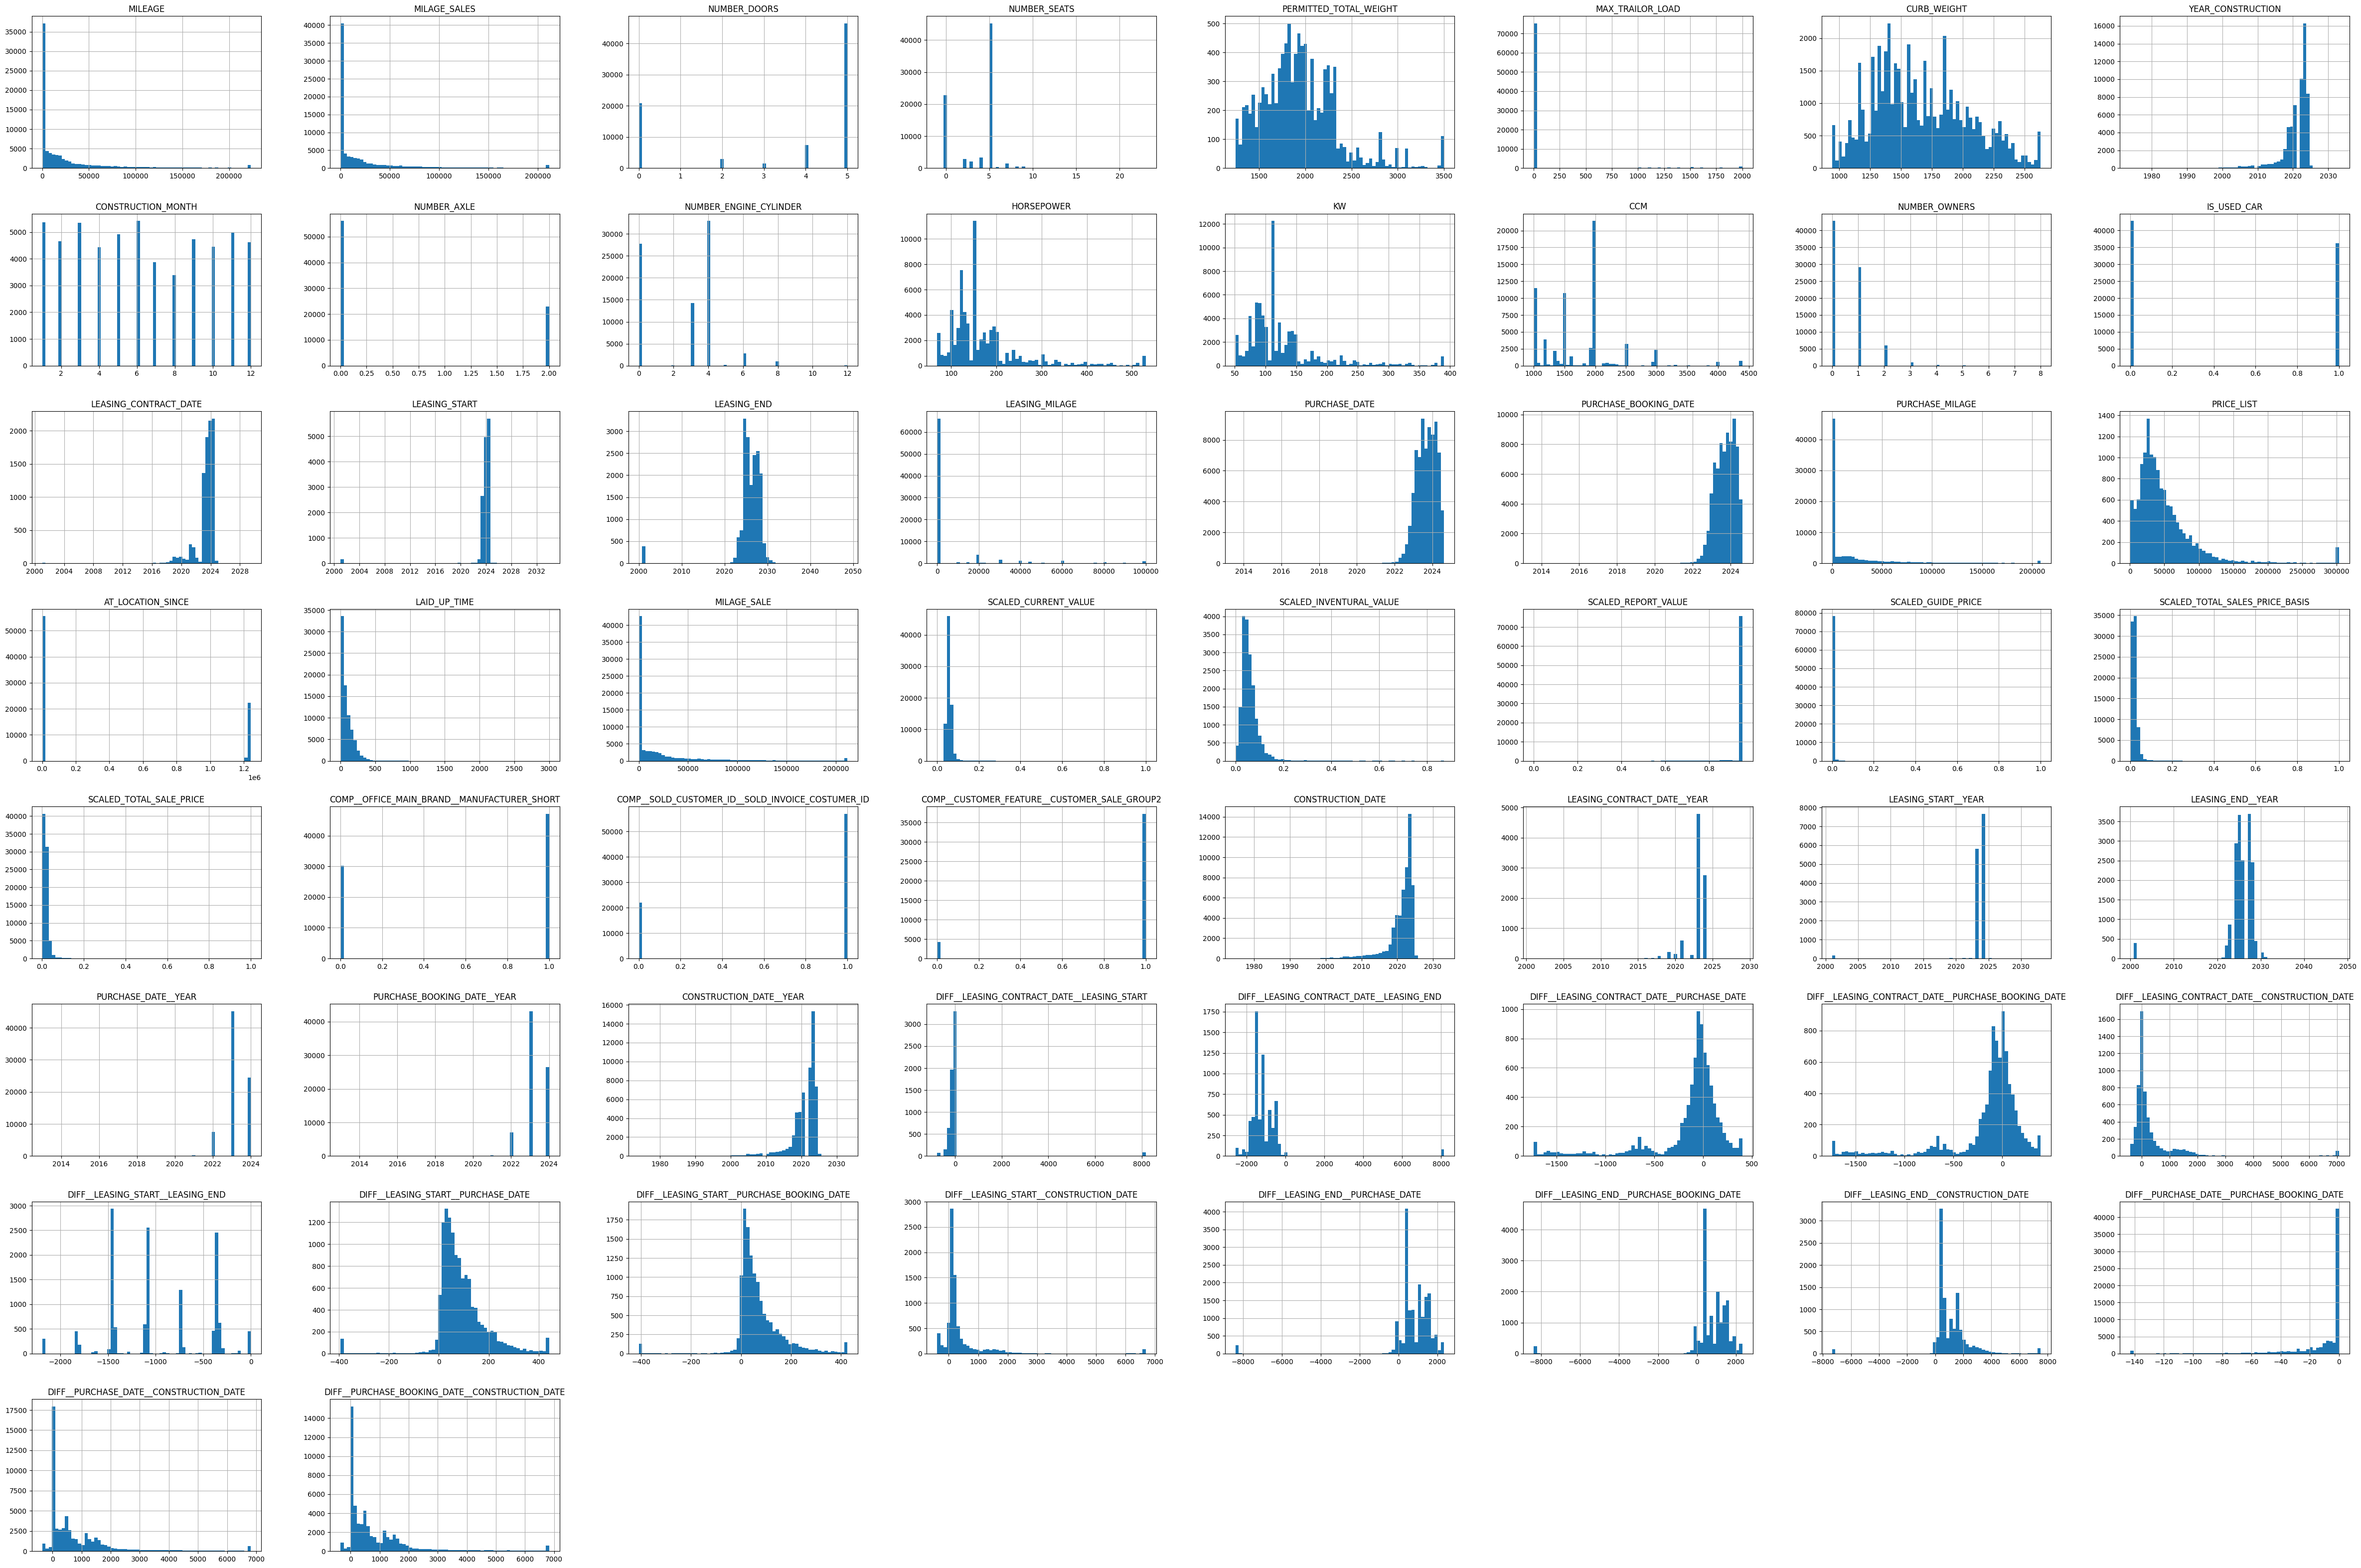

In [51]:
df_train_train_prep.hist(bins=64, figsize=(60, 40))
plt.show()

In [52]:
corr_matrix = df_train_train_prep.select_dtypes(include=dtypes["num"]).corr()
print(corr_matrix["LAID_UP_TIME"][corr_matrix["LAID_UP_TIME"].notna()].sort_values(ascending=False))

LAID_UP_TIME                                          1.000000
DIFF__LEASING_START__PURCHASE_DATE                    0.709864
DIFF__LEASING_START__PURCHASE_BOOKING_DATE            0.601654
DIFF__LEASING_CONTRACT_DATE__PURCHASE_DATE            0.164223
DIFF__LEASING_CONTRACT_DATE__PURCHASE_BOOKING_DATE    0.156077
DIFF__LEASING_END__PURCHASE_DATE                      0.138521
DIFF__LEASING_END__PURCHASE_BOOKING_DATE              0.128252
CONSTRUCTION_DATE__YEAR                               0.115616
YEAR_CONSTRUCTION                                     0.100359
LEASING_END__YEAR                                     0.098522
AT_LOCATION_SINCE                                     0.096517
DIFF__LEASING_START__LEASING_END                      0.096403
LEASING_START__YEAR                                   0.093664
NUMBER_AXLE                                           0.066776
COMP__SOLD_CUSTOMER_ID__SOLD_INVOICE_COSTUMER_ID      0.053607
IS_USED_CAR                                           0

### Split features and labels

In [53]:
X_train_train, y_train_train = split_data_frame(df_train_train_prep)
X_train_test, y_train_test = split_data_frame(df_train_test_prep)

### Inspect LAID_UP_TIME

mean: 88.33501517450682
std: 95.79825142064274


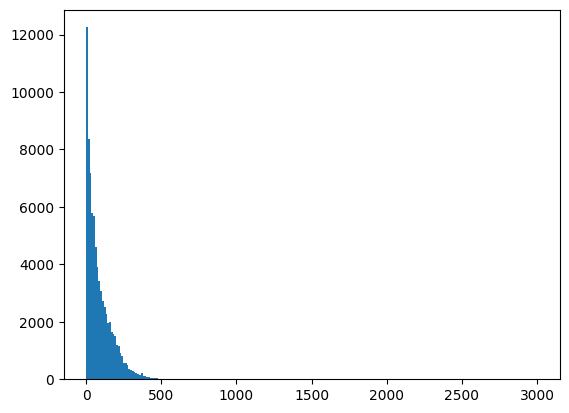

In [54]:
print(f"mean: {np.mean(y_train_train)}")
print(f"std: {np.std(y_train_train)}")
plt.hist(y_train_train, bins=256)
plt.show()

## Preprocessing

### Preprocessing pipeline

In [207]:
def map_date(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.map(lambda date: date_to_number(date))


def date_to_number(date: np.datetime64) -> np.float64:
    if date is pd.NaT:
        return np.nan
    return date.year + date.month / 12.0 + date.day / (12.0 * monthrange(date.year, date.month)[1])


def create_preprocessor(
    keep_dates: bool = True,
    keep_nums: bool = True,
    keep_strs: bool = True,
    encoding: str = "one_hot",
    use_feat_aggl: bool = True,
) -> Pipeline:
    date_transformer = Pipeline([
        ("converter", FunctionTransformer(map_date)),
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
    ])

    num_transformer = Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
    ])

    str_transformers = [
        ("imputer", SimpleImputer(missing_values=pd.NA, strategy="constant", keep_empty_features=True, fill_value="N/A")),
    ]
    if encoding == "one_hot":
        str_transformers.append(("encoder", OneHotEncoder(min_frequency=0.05, handle_unknown="infrequent_if_exist", sparse_output=False)))
    elif encoding == "ordinal":
        str_transformers.append(("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)))
    else:
        raise Exception("unsupported encoding")
    str_transformer = Pipeline(str_transformers)

    per_dtype_transformers = []
    if keep_dates:
        per_dtype_transformers.append(\
            ("date", date_transformer, make_column_selector(dtype_include=dtypes["date"])))
    if keep_nums:
        per_dtype_transformers.append(\
            ("num", num_transformer, make_column_selector(dtype_include=dtypes["num"])))
    if keep_strs:
        per_dtype_transformers.append(\
            ("str", str_transformer, make_column_selector(dtype_include=dtypes["str"])))
    
    final_pipeline_transformers = [
        ("per_dtype", ColumnTransformer(per_dtype_transformers)),
        ("variance_threshold", VarianceThreshold()),
    ]
    if use_feat_aggl:
        final_pipeline_transformers.append(\
            ("feature_agglomeration", FeatureAgglomeration(n_clusters=None, compute_full_tree=True, distance_threshold=10.0)))

    return Pipeline(final_pipeline_transformers)

### Inspect preprocessing pipeline

In [208]:
create_preprocessor()

Pipeline(steps=[('per_dtype',
                 ColumnTransformer(transformers=[('date',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function map_date at 0x000001A52A243100>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A566EDBB90>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleIm...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A566EDB290>)])),
                ('variance_threshold', VarianceThreshold()),
                ('feature_agglomeration',
                 FeatureAgglomeration(compute_full_tree=True,
                                      distance_threshold=10.0,
                                      n_clusters=None))])

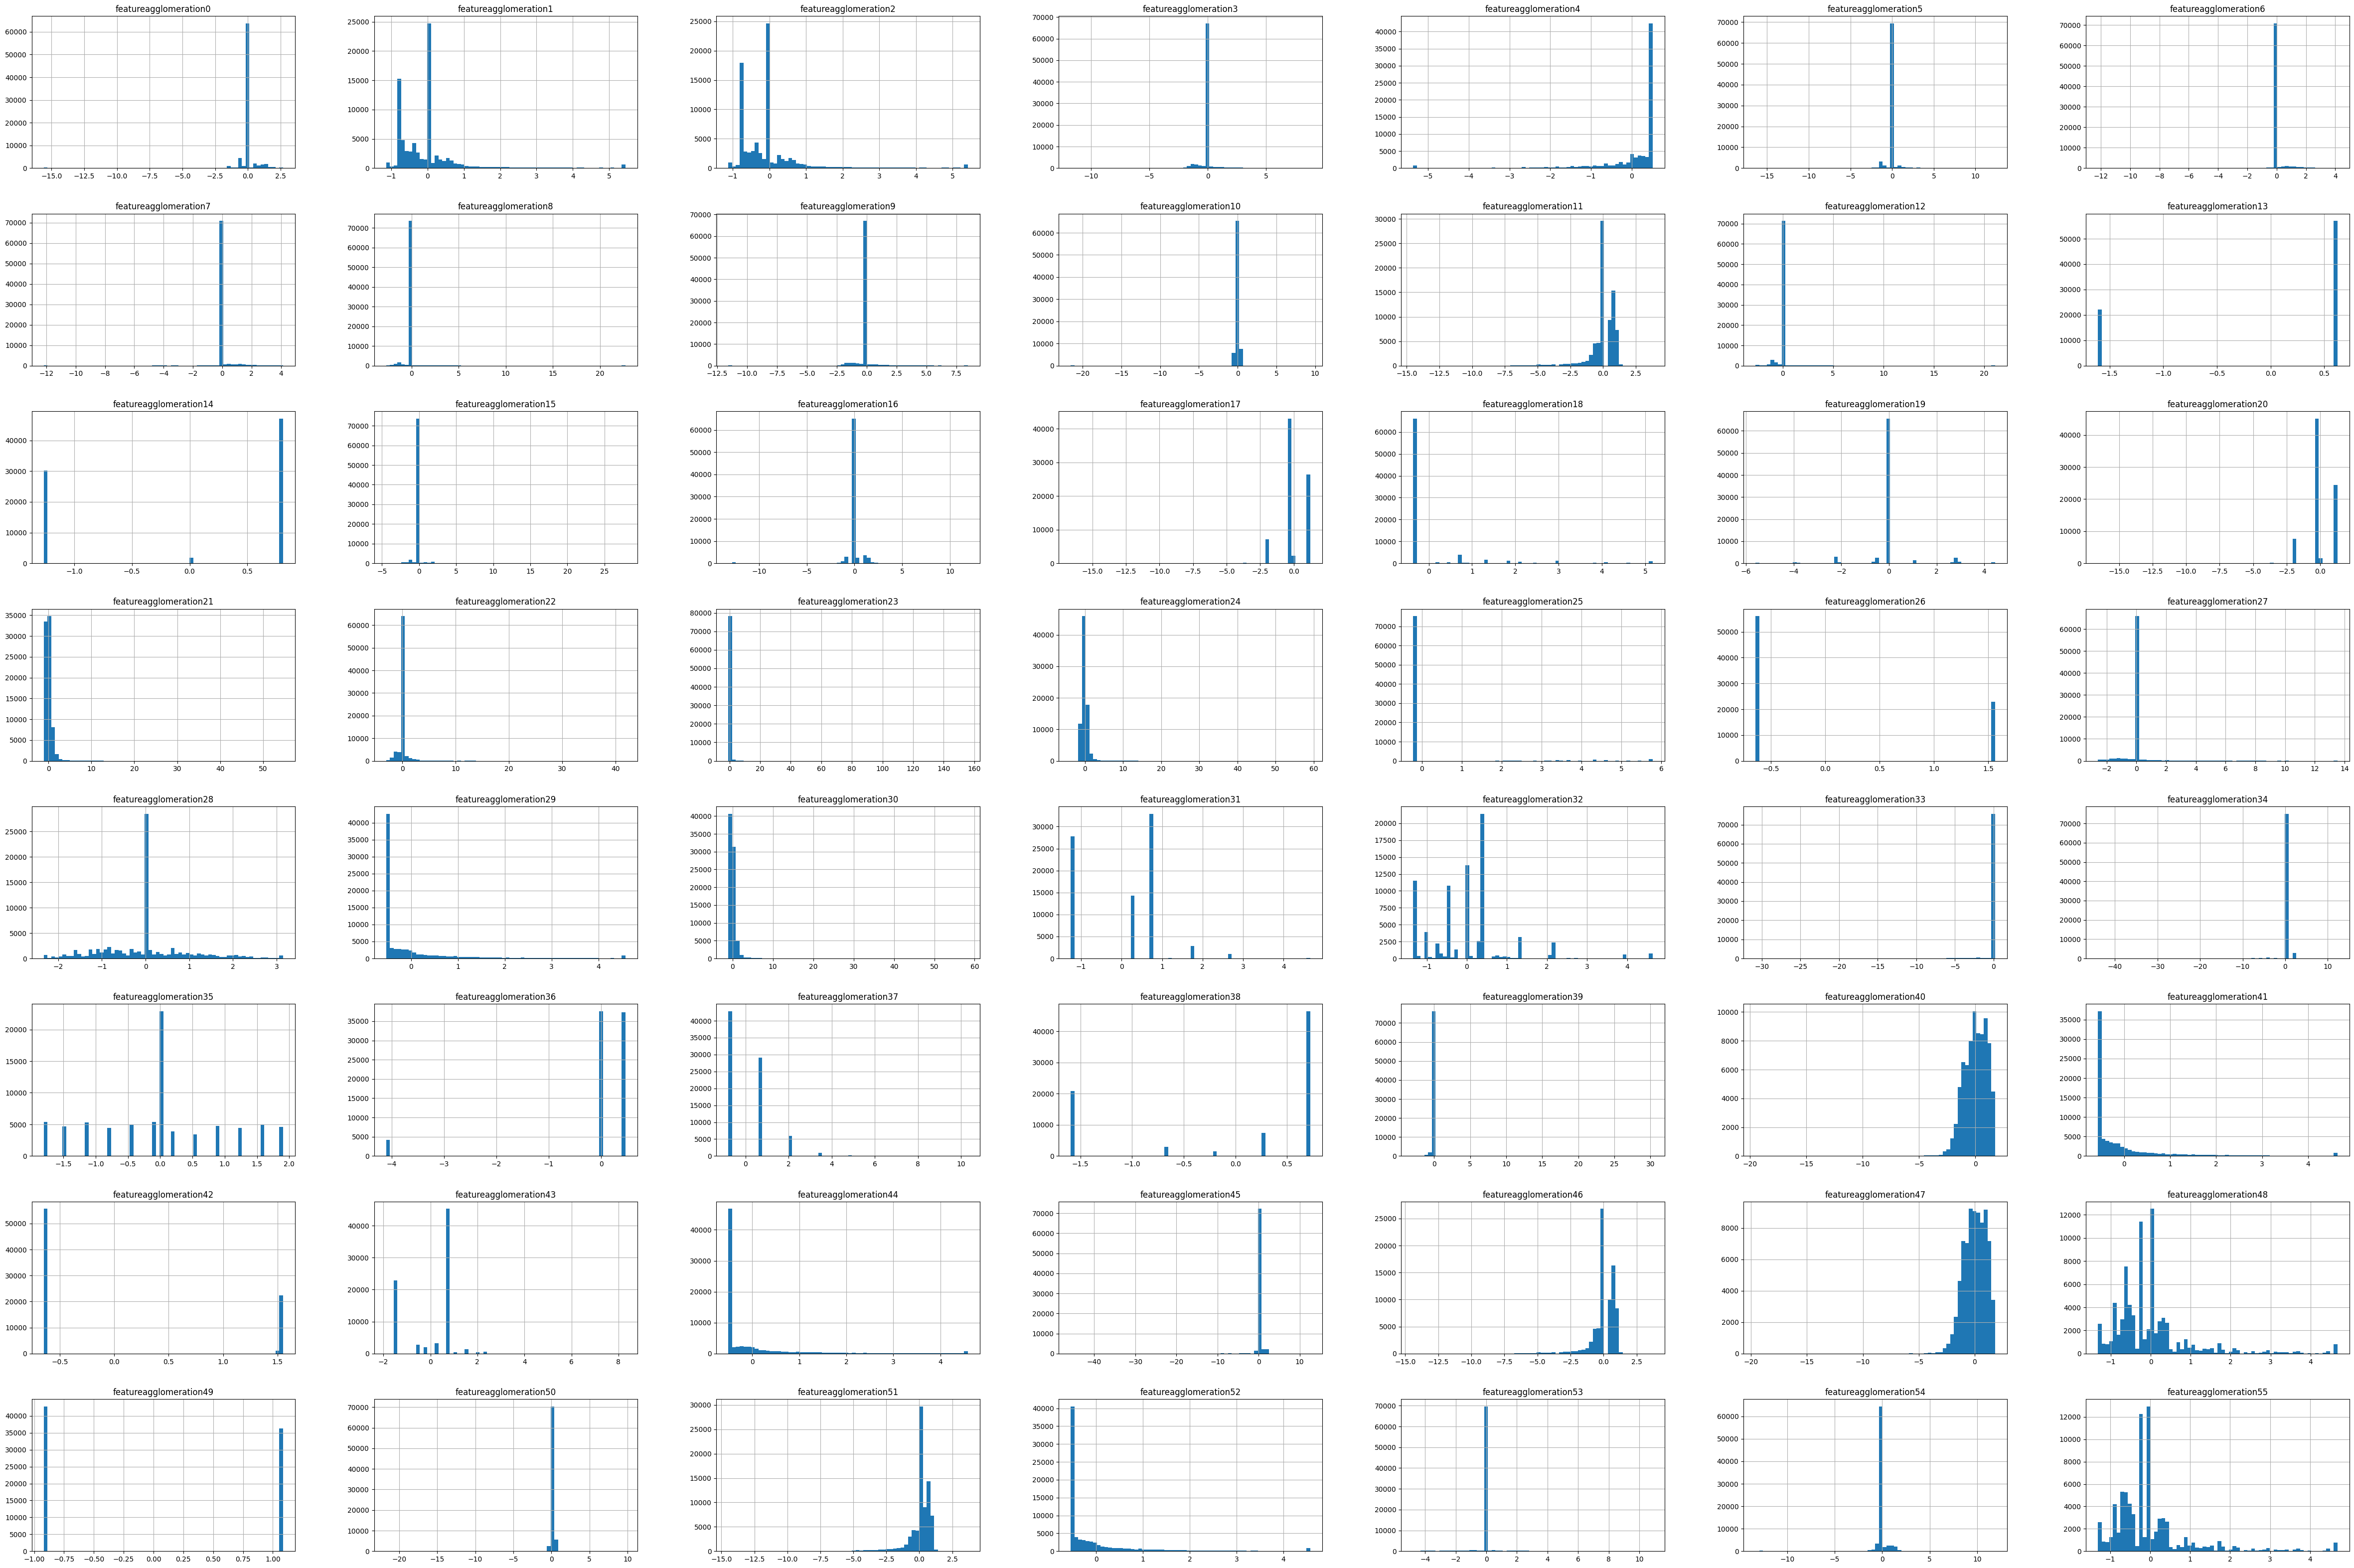

In [78]:
preprocessor = create_preprocessor(keep_strs=False)
preprocessor.set_output(transform="pandas")
X_train_prep: pd.DataFrame = preprocessor.fit_transform(X_train_train, y_train_train)
X_train_prep.hist(bins=64, figsize=(60, 40))
plt.show()

In [79]:
preprocessor = create_preprocessor()
preprocessor.set_output(transform="pandas")
X_train_prep: pd.DataFrame = preprocessor.fit_transform(X_train_train, y_train_train)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79080 entries, 11190 to 68268
Columns: 250 entries, featureagglomeration0 to featureagglomeration249
dtypes: float64(250)
memory usage: 151.4 MB


In [80]:
preprocessor_no_feat_aggl = create_preprocessor(use_feat_aggl=False)
preprocessor_no_feat_aggl.set_output(transform="pandas")
X_train_prep_no_feat_aggl: pd.DataFrame = preprocessor_no_feat_aggl.fit_transform(X_train_train, y_train_train)

for agg_idx in range(preprocessor["feature_agglomeration"].n_clusters_):
    line = f"{agg_idx}: "
    for col in X_train_prep_no_feat_aggl.columns[preprocessor["feature_agglomeration"].labels_ == agg_idx]:
        line += f"{col}, "
    print(line)

0: str__MANUFACTURER_SHORT_infrequent_sklearn, str__MANUFACTURER_infrequent_sklearn, 
1: str__MANUFACTURER_SHORT_WDB, str__MANUFACTURER_MERCEDES, 
2: num__DIFF__LEASING_END__PURCHASE_DATE, num__DIFF__LEASING_END__PURCHASE_BOOKING_DATE, 
3: str__LEASING_END__MONTH_N/A, str__LEASING_END__DAY_N/A, str__LEASING_END__WEEKDAY_N/A, 
4: str__MANUFACTURER_SHORT_V, str__MANUFACTURER_VW, 
5: str__CUSTOMER_SALE_GROUP2_N/A, str__CUSTOMER_SALE_GROUP2_NAME_N/A, 
6: str__COMPANY_33.0, str__OFFICE_MAIN_BRAND_V, 
7: str__LEASING_CONTRACT_DATE__MONTH_N/A, str__LEASING_CONTRACT_DATE__DAY_N/A, str__LEASING_CONTRACT_DATE__WEEKDAY_N/A, 
8: str__VEHICLE_MODEL_ID_1.0, str__VEHICLE_MODEL_ID_NAME_LIMOUSINE, 
9: str__VEHICLE_MODEL_ID_0.0, str__VEHICLE_MODEL_ID_NAME_N/A, 
10: str__CUSTOMER_TYPE_N/A, str__CUSTOMER_FEATURE_N/A, str__CUSTOMER_FEATURE_NAME_N/A, 
11: str__CUSTOMER_FEATURE_infrequent_sklearn, str__CUSTOMER_FEATURE_NAME_infrequent_sklearn, 
12: str__FUEL_TYPE_infrequent_sklearn, str__FUEL_TYPE_NAME_infre

## Model selection

### Helper functions

In [81]:
def validate_model(model: BaseEstimator):
    X_val_train, X_val, y_val_train, y_val = train_test_split(X_train_train, y_train_train, test_size=0.2, random_state=12) 
    model.fit(X_val_train, y_val_train)
    y_pred = model.predict(X_val)
    print("RMSE:", root_mean_squared_error(y_val, y_pred))

In [82]:
def cross_validate_model(model: BaseEstimator):
    scores = cross_val_score(model, X_train_train, y_train_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("RMSE Std:", rmse_scores.std())

In [194]:
def hyper_param_tune_model(model: BaseEstimator, param_grid):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        verbose=4,
    )

    grid_search.fit(X_train_train, y_train_train)

    print("Results:")
    for params, rmse in zip(grid_search.cv_results_["params"], np.sqrt(-grid_search.cv_results_["mean_test_score"])):
        print(f"{params}:\t {rmse}")
    print("Best Parameters:", grid_search.best_params_)
    print("Best RMSE:", np.sqrt(-grid_search.best_score_))

In [202]:
def inspect_model_feature_importance(model: BaseEstimator, n_repeats: int = 5):
    X_val_train, X_val, y_val_train, y_val = train_test_split(X_train_train, y_train_train, test_size=0.2, random_state=12) 
    model.fit(X_val_train, y_val_train)
    y_pred = model.predict(X_val)
    print("RMSE:", root_mean_squared_error(y_val, y_pred))

    r = permutation_importance(model, X_val, y_val, n_repeats=n_repeats, n_jobs=-1, random_state=56)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_train_train.columns[i]:<60} {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")
    
    return r

In [83]:
def test_model(model: BaseEstimator):
    model.fit(X_train_train, y_train_train)
    y_pred = model.predict(X_train_test)
    print("RMSE:", root_mean_squared_error(y_train_test, y_pred))

### Linear Regression

In [84]:
linear_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectKBest(f_regression, k=60)),
    ("regressor", LinearRegression(n_jobs=-1)),
])
cross_validate_model(linear_reg)

RMSE Scores: [69.96867868 70.32330129 70.28118904 74.00607369 69.66611864]
RMSE Mean: 70.84907227003171
RMSE Std: 1.5962491395164171


### Random Forest Regressor

In [85]:
rng = np.random.RandomState(42)
rand_forest_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectKBest(f_regression, k=60)),
    ("regressor", RandomForestRegressor(n_jobs=-1, random_state=rng)),
])
cross_validate_model(rand_forest_reg)

RMSE Scores: [47.08969131 48.78740969 46.47288311 53.45011288 48.3512623 ]
RMSE Mean: 48.83027185566891
RMSE Std: 2.456058662200331


### Histogram-Based Gradient Boosting Regressor

In [161]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", HistGradientBoostingRegressor(random_state=rng)),
])

In [166]:
param_grid = {
    "regressor__max_iter": [50, 100, 200],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Results:
{'regressor__max_iter': 50}:	 48.78868486600133
{'regressor__max_iter': 100}:	 46.359100013084756
{'regressor__max_iter': 200}:	 44.49527029287379
Best Parameters: {'regressor__max_iter': 200}
Best RMSE: 44.49527029287379


In [108]:
param_grid = {
    "regressor__learning_rate": [0.05, 0.1, 0.2],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Results:
{'regressor__learning_rate': 0.025}:	 53.1758646109793
{'regressor__learning_rate': 0.05}:	 48.749839912349074
{'regressor__learning_rate': 0.1}:	 46.359100013084756
{'regressor__learning_rate': 0.2}:	 44.963075066431664
{'regressor__learning_rate': 0.4}:	 44.89745453119124
Best Parameters: {'regressor__learning_rate': 0.4}
Best RMSE: 44.89745453119124


In [109]:
param_grid = {
    "regressor__max_leaf_nodes": [16, 31, 62],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Results:
{'regressor__max_leaf_nodes': 8}:	 53.20420892653611
{'regressor__max_leaf_nodes': 16}:	 49.06565974765244
{'regressor__max_leaf_nodes': 31}:	 46.359100013084756
{'regressor__max_leaf_nodes': 62}:	 44.25924344644921
{'regressor__max_leaf_nodes': 124}:	 42.816649063044615
Best Parameters: {'regressor__max_leaf_nodes': 124}
Best RMSE: 42.816649063044615


In [110]:
param_grid = {
    "regressor__min_samples_leaf": [10, 20, 40],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Results:
{'regressor__min_samples_leaf': 10}:	 46.272342036054546
{'regressor__min_samples_leaf': 20}:	 46.359100013084756
{'regressor__min_samples_leaf': 40}:	 46.54280266083353
Best Parameters: {'regressor__min_samples_leaf': 10}
Best RMSE: 46.272342036054546


In [111]:
param_grid = {
    "regressor__max_features": [0.5, 0.8, 1.0],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Results:
{'regressor__max_features': 0.5}:	 46.53564295933065
{'regressor__max_features': 0.8}:	 46.421541359901205
{'regressor__max_features': 1.0}:	 46.359100013084756
Best Parameters: {'regressor__max_features': 1.0}
Best RMSE: 46.359100013084756


In [113]:
param_grid = {
    "regressor__max_iter": [50, 100, 200],
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__max_leaf_nodes": [16, 31, 62],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results:
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 50, 'regressor__max_leaf_nodes': 16}:	 56.85576296398983
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 50, 'regressor__max_leaf_nodes': 31}:	 53.09978189924875
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 50, 'regressor__max_leaf_nodes': 62}:	 50.22667247820098
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 100, 'regressor__max_leaf_nodes': 16}:	 51.96818436518304
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 100, 'regressor__max_leaf_nodes': 31}:	 48.749839912349074
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 100, 'regressor__max_leaf_nodes': 62}:	 46.209991163094955
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 16}:	 49.16146625095154
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 31}:	 46.343723316981546
{

In [114]:
param_grid = {
    "regressor__max_iter": [200, 400, 800],
    "regressor__learning_rate": [0.2, 0.3, 0.4],
    "regressor__max_leaf_nodes": [62, 80, 100],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results:
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 62}:	 42.21065536228942
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 80}:	 42.13932770418757
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 100}:	 41.81815001985694
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 62}:	 41.90262201193768
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 80}:	 42.010714592505586
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 100}:	 41.78200145814578
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 800, 'regressor__max_leaf_nodes': 62}:	 41.90262201193768
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 800, 'regressor__max_leaf_nodes': 80}:	 42.010714592505586
{'reg

In [115]:
param_grid = {
    "regressor__max_iter": [300, 350, 400],
    "regressor__learning_rate": [0.15, 0.2, 0.25],
    "regressor__max_leaf_nodes": [90, 100, 110],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results:
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 300, 'regressor__max_leaf_nodes': 90}:	 41.378579208230164
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 300, 'regressor__max_leaf_nodes': 100}:	 41.39452448181755
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 300, 'regressor__max_leaf_nodes': 110}:	 41.39562797527731
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 350, 'regressor__max_leaf_nodes': 90}:	 41.30223249886669
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 350, 'regressor__max_leaf_nodes': 100}:	 41.33160541035381
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 350, 'regressor__max_leaf_nodes': 110}:	 41.37596117032739
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 90}:	 41.24481349875672
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 100}:	 41.2896385625

In [124]:
hist_grad_boost_reg.set_params(**{
    "regressor__max_iter": 400,
    "regressor__learning_rate": 0.15,
    "regressor__max_leaf_nodes": 90,
})
cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [39.75046336 40.78664595 39.33099351 45.89833488 40.10535103]
RMSE Mean: 41.1743577486141
RMSE Std: 2.409751965735565


In [130]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectKBest(mutual_info_regression, k=100)),
    ("regressor", HistGradientBoostingRegressor(max_iter=400, learning_rate=0.15, max_leaf_nodes=90, random_state=rng)),
])
cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [41.5419295  41.93369636 40.90521818 46.92324312 42.20734227]
RMSE Mean: 42.70228588356089
RMSE Std: 2.155368102018527


In [136]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectKBest(mutual_info_regression, k=20)),
    ("regressor", HistGradientBoostingRegressor(max_iter=400, learning_rate=0.15, max_leaf_nodes=90, random_state=rng)),
])
cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [47.39185271 47.49198783 47.18574093 52.55529061 48.83495197]
RMSE Mean: 48.69196481171342
RMSE Std: 2.017160289980203


In [204]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", HistGradientBoostingRegressor(max_iter=400, learning_rate=0.15, max_leaf_nodes=90, random_state=rng)),
])
importance = inspect_model_feature_importance(hist_grad_boost_reg)

RMSE: 38.78895469835965
PURCHASE_DATE                                                0.725 +/- 0.013
AT_LOCATION_SINCE                                            0.242 +/- 0.005
SCALED_CURRENT_VALUE                                         0.227 +/- 0.003
SCALED_INVENTURAL_VALUE                                      0.193 +/- 0.006
PURCHASE_DATE__YEAR                                          0.092 +/- 0.003
DIFF__PURCHASE_DATE__PURCHASE_BOOKING_DATE                   0.083 +/- 0.002
MILAGE_SALE                                                  0.059 +/- 0.003
COMMISSION_TYPE_NAME                                         0.057 +/- 0.001
COMMISSION_TYPE                                              0.057 +/- 0.001
SCALED_TOTAL_SALE_PRICE                                      0.054 +/- 0.001
ENGINE_TYPE                                                  0.044 +/- 0.001
PURCHASE_BOOKING_DATE                                        0.035 +/- 0.001
DIFF__LEASING_START__PURCHASE_DATE                  

In [231]:
import sklearn
sklearn.set_config(
   assume_finite=True,  # disable validation
)


def perm_feat_importance_selector(X, y) -> np.array:
    return importance.importances_mean


rng = np.random.RandomState(42)
selector = SelectKBest(perm_feat_importance_selector, k=50)
selector.set_output(transform="pandas")

hist_grad_boost_reg = Pipeline([
    ("selector", selector),
    ("preprocessor", create_preprocessor()),
    ("regressor", HistGradientBoostingRegressor(max_iter=400, learning_rate=0.15, max_leaf_nodes=90, random_state=rng)),
])

cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [39.94166869 40.9833168  39.24079453 46.20303789 40.66379148]
RMSE Mean: 41.40652187839211
RMSE Std: 2.4727914041379964


### LightGBM

In [170]:
import lightgbm as lgb

rng = np.random.RandomState(42)

param_grid = {
    'regressor__boosting_type': ['dart'],
    # 'regressor__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'regressor__learning_rate': [0.1],
    'regressor__n_estimators': [10, 20, 30],
    'regressor__num_leaves': [10],
    'regressor__max_depth': [20],
    'regressor__min_child_samples': [20],
    # 'regressor__colsample_bytree': [0.2, 0.4, 0.6],
    'regressor__colsample_bytree': [0.6],
    # 'regressor__min_child_weight': [1e-3, 1e-2, 0.1],
    # 'regressor__min_split_gain': [0.0, 0.01, 0.1],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'subsample_freq': [1, 5, 10],
}

lgbm_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", lgb.LGBMRegressor(random_state=rng, n_estimators=1000, n_jobs=29)),
])

grid_search = GridSearchCV(
    estimator=lgbm_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=4
)

grid_search.fit(X_train_train, y_train_train)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# cross_validate_model(lgbm_reg)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\simon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9378
[LightGBM] [Info] Number of data points in the train set: 79080, number of used features: 250
[LightGBM] [Info] Start training from score 88.335015
Best Parameters: {'regressor__boosting_type': 'dart', 'regressor__colsample_bytree': 0.6, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 20, 'regressor__min_child_samples': 20, 'regressor__n_estimators': 30, 'regressor__num_leaves': 10}
Best RMSE: 62.95002651869723


### Select final model

In [229]:
final_model = hist_grad_boost_reg

## Evaluate model on the test set

In [230]:
test_model(final_model)

RMSE: 69.30896637546671


## Train final model on the full data set

In [68]:
df_train_prep = prepare_data_frame(df_train, is_test=False, drop_rows=True)
X_train, y_train = split_data_frame(df_train_prep)
final_model.fit(X_train, y_train);

## Load test data frame

In [69]:
df_new = pd.read_excel("data/Vehicles_export_prices_scaled_stud_test_eng.xlsx")

In [70]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42425 entries, 0 to 42424
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(15), int64(26), object(60)
memory usage: 34.3+ MB


In [71]:
df_new_prep = prepare_data_frame(df_new, is_test=True, drop_rows=False)

In [72]:
df_new_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42425 entries, 0 to 42424
Columns: 125 entries, COMPANY to DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
dtypes: datetime64[ns](6), float64(52), string(67)
memory usage: 40.5 MB


## Predict test data values

In [73]:
X_new, _ = split_data_frame(df_new_prep)
y_new = final_model.predict(X_new)

## Save predicted test data values

In [74]:
def save_to_xlsx(features: pd.DataFrame, predictions: np.array, filename: str):
    output_dir = "predictions"
    os.makedirs(output_dir, exist_ok=True)
    
    df_output = features.copy()
    df_output["LAID_UP_TIME"] = predictions
    df_output[["CHASSIS_NUMBER", "LAID_UP_TIME"]].to_excel(f"{output_dir}/{filename}", index = False)

In [75]:
save_to_xlsx(X_new, y_new, "teamA-model1.xlsx")

Next steps:
- better feature selection (e.g. PCA)
- GridSearch
- Round predictions
- outlier detection
- per feature mapping (to nulls, etc.)